# Introduction to Azure Machine Learning Workshop
## AutoML Classification

In this workshop we will use the [Azure Machine Learning SDK for Python](https://docs.microsoft.com/en-us/python/api/overview/azure/ml/intro?view=azure-ml-py) as well as Automated Machine Learning services from Azure to predict and flag students who are at risk of dropping a course. 

### Prerequisites
 - Access to an Azure Subscription
 - Completion of the [Azure Fundamentals Lab](https://aka.ms/edu/Azure101)
 
 
### Task List
- [Create an Azure Machine Learning Services Workspace](#Create-an-Azure-Machine-Learning-Services-Workspace)
- Connect to the Azure Machine Learning Services Workspace
- Load data from Azure Blob Storage
- Transform and prepare data
- Configure AutoML Experiment
- Run AutoML Experiment & Explore Results
- Retreive and Test AutoML model
- Apply AutoML model to whole dataset


## Create an Azure Machine Learning Services Workspace
1. Sign in to the [Azure portal](https://portal.azure.com/).
1. Click **Create a resource** in the upper left-hand corner of the Azure portal.
1. In the Search field, type in *Machine Learning* and choose **Machine Learning Service Workspace**
![Create Machine Learning Workspace](media/1.png)
1. Click on the **Create** button and fill out the Resource Creation form accordingly, then click **Review + Create**, followed by **Create**.
![Create Machine Learning Workspace](media/2.png)

| Setting | Suggested value   |
|------|------|
|**Wokrspace Name**  | Your Workspace Name|
|**Subscription**  | The subscription associated with your account.|
|**Resource group**  | Create a new resoruce group for this workshop.|
|**Location**  | Use the location nearest you.|

5. Go to the Workspace once it has been deployed and retrieve the:
    - Subscription ID
    - Resource Group Name
    - Workspace Name
![Retrieve workspace settings](media/3.png)
1. From the same page, click on the **Storage** hyperlink.
1. From the Storage Account Overview, click on **Access Keys**, and retrieve **key2**
![Retrieve workspace settings](media/4.png)

## Connect to the Azure Machine Learning Services Workspace
For Azure AutoML, you will need to create an **Experiment**, which is a named object in your Machine Learning Workspace used to run experiments.

1. First, we will import the Azure Machine Learning Service and Logging libraries and validate SDK version.

In [336]:
import azureml.core
import logging

In [337]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.0.60 of the Azure ML SDK


2. Next, we define variables with the values we retrived for our **Subscription ID**, **Resource Group Name**, and **Machine Learning Workspace Name.** 

In [338]:
subscription_id = 'ba5f14ba-32b2-4d29-b115-919f9253bfb0'
resource_group  = 'crice-ML'
workspace_name  = 'crice-mlwkspace'

3. We will now use those variables to ensure that the Machine Learning Workspace exists, and we are able to connect to it.

    If the result of the following cell is 'Workspace not found,' review the variables we defined in the previous step to ensure they match the values from [Create an Azure Machine Learning Services Workspace](#Create-an-Azure-Machine-Learning-Services-Workspace).

In [339]:
from azureml.core import Workspace
try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    ws.write_config()
    print('Library configuration succeeded')
except:
    print('Workspace not found')

Library configuration succeeded


## Load data from Azure Blob Storage
1. Now we will connect to Azure Blob Storage. To do so, we will first import the Azure Storage library.

In [340]:
from azure.storage.blob import BlockBlobService
#import tables

2. Next, we will define variables that correspond to our storage account, and the location of the data we'll be creating the model from.

In [342]:
storageaccount_name = 'cricemlwkspace5282265852'
storageaccount_key = 'jnkW0pR3ZIt36pmyXwoWMjMoOeI7gugOmITogQO36Xelm4LvoETmLxqgwSl14PYRehrSxf0phPgV3rHMNeSmMA=='

local_filename = './MLInput.tsv'
container_name = 'sources'
blob_name = 'MLInput.tsv'

3. We'll use the variables from step 2 to create a connection to Blob storage and retrive the data.

In [343]:
#download from blob

blob_service=BlockBlobService(account_name=storageaccount_name,account_key=storageaccount_key)
blob_service.get_blob_to_path(container_name,blob_name,local_filename)


4. Now we'll load the blob data into a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). A Data frame is a two-dimensional data structure, i.e., data is aligned in a tabular fashion in rows and columns. Pandas DataFrame consists of three principal components, the data, rows, and columns.

In [354]:
import pandas as pd

studentDropDF = pd.read_csv(local_filename, sep='\t', index_col=0)

studentDropDF = studentDropDF.dropna(axis=1,how='any')


5. Now that the data is stored in a Data Frame, we can display it to explore the data and gain context.

In [351]:
display(studentDropDF)

,TermID,SubjectID,CatalogID,ClassID,SectionID,EnrollDate,Gender,Age,City,StateAbbrev,...,AdmitTerm,Term,SchoolYear,Subject,Catalog,Section,Class,CreditHours,Dropped,MidTermGrade
StudentID,,,,,,,,,,,,,,,,,,,,,
18023,2074,ACC-UB,301,1,UB2,20061127,FEMALE,28,Camden,NJ,...,2048,Spring,2007,ACC-UB,301,UB2,Intermediate Accounting I,3,0,-
5041,2074,ACC-UB,405,2,101,20070117,MALE,26,Rockville,MD,...,2068,Spring,2007,ACC-UB,405,101,Income Taxation,3,0,-
657,2054,ADLT,473,3,1,20041219,MALE,27,Randallstown,MD,...,2048,Spring,2005,ADLT,473,1,PRC AD HEA&DEV PR,3,0,S
390,2064,ANTH,207,4,1,20060130,FEMALE,34,Baltimore,MD,...,2048,Spring,2006,ANTH,207,1,CULTURAL ANTH,3,1,-
700,2064,ANTH,207,4,1,20051208,MALE,30,Baltimore,MD,...,2048,Spring,2006,ANTH,207,1,CULTURAL ANTH,3,0,D
793,2074,ANTH,207,4,1,20070125,MALE,48,Baltimore,MD,...,2054,Spring,2007,ANTH,207,1,CULTURAL ANTH,3,0,S
812,2074,ANTH,207,4,1,20070123,FEMALE,34,Baltimore,MD,...,2048,Spring,2007,ANTH,207,1,CULTURAL ANTH,3,0,F
830,2074,ANTH,207,4,1,20070209,FEMALE,41,Baltimore,MD,...,2058,Spring,2007,ANTH,207,1,CULTURAL ANTH,3,0,D
947,2074,ANTH,207,4,1,20070117,FEMALE,64,Baltimore,MD,...,2058,Spring,2007,ANTH,207,1,CULTURAL ANTH,3,0,S


## Transform and prepare data
1. First, we will split the data into two data frames. One for indepedent variables (studentDropDF_X) and one for the depedent variable (studentDropDF_y.)

    For our analysis the depdent variable will be **Dropped**, where 1 indicates a course was dropped and 0 indicates the opposite.

In [352]:
studentDropDF_x = studentDropDF.drop("Dropped", axis=1)
studentDropDF_y = studentDropDF.filter(["Dropped"], axis=1)

2. Now we will import train_test_split from the sklearn library so that we may segment the dataframes further into two sets of data:

    - **x_train** and **y_train**: Will have 70% of all the data and be used to train our model.
    - **x_test** and **y_test**: Will have 30% of all the data and be used to validate the result of our training.

In [353]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(studentDropDF_x,studentDropDF_y, test_size=0.3, random_state=1234)

In [355]:
## Remove comment to view dataframes
#display(x_train)
#display(x_test)
#display(y_train)
#display(y_test)

## Configure AutoML Experiment

Begin to configure the AutoML by instantiating an AutoMLConfig object to define the settings and data used to run the expirement ([documentation link](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#configure-your-experiment-settings)). 

1. We will first define the Experiment Name, which will correspond to generated expirement in your Machine Learning Workspace. 


In [358]:
experiment_name = 'automated-ml-classification'
project_folder = './automated-ml-classification'

2. Next, import AutoMLConfig from the AzureML Library, define our automl_settings, and instantiate the AutoMLConfig object.



| Setting | Description   |
|------|------|
|**task**  | classification or regression|
|**primary_metric**  | Determines the metric to be used during model training for optimization.|
|**iterations**  | Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**iteration_timeout_minutes**  | Define a time limit in minutes per each iteration.|
|[**preprocess**](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml#preprocess) | Advanced preprocessing and featurization (e.g. missing value imputation, categorization)|
|**X** | Indepdent variable array |
|**Y** | Depdent variable array|

In [359]:
from azureml.train.automl import AutoMLConfig


automl_settings = {
  "iteration_timeout_minutes" : 5,
  "iterations" : 5,
  "primary_metric" : 'accuracy',
  "preprocess" : True,
  "verbosity" : logging.INFO,
  "n_cross_validations": 5
}

automl_config = AutoMLConfig(
                             task = 'classification',
                             debug_log = 'automated_ml_errors.log',
                             path = project_folder,
                             X = x_train,
                             y = y_train,
                             **automl_settings)

## Run AutoML Experiment & Explore Results
1. Now we will instantiate an Expirement object using the AutoMLConfig object we created, and submit the expirement to **run** in Azure. 

In [360]:
from azureml.core.experiment import Experiment

ws = Workspace.from_config()
experiment = Experiment(ws, experiment_name)

2. Depending on compute, complexity, and the number of iterations, the expirement may take some time to run; however, we will be able to monitor the progress of the run by turning **show_output** to equal **True**.

In [361]:
run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_963d3fd5-3174-4926-8c06-cff4836d5fc0
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS SUMMARY:
For more details, use API: run.get_guardrails()

TYPE:         Missing Values Imputation
STATUS:       FIXED
DESCRIPTION:  The training data had the following missing values which were resolved.

Please review your data source for data quality issues and possibly filter out the rows with these missing values.

If the missing values are expected, you can either accept the above imputation, or implement

3. Explore the result of the expirement by going to the [Azure portal](https://portal.azure.com), or by levarging the **RunDetails** widget.

    After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

In [362]:
from azureml.widgets import RunDetails
RunDetails(run).show()

A Jupyter Widget

4. You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [363]:
children = list(run.get_children())
metricslist = {}
for r in children:
    properties = r.get_properties()
    metrics = {k: v for k, v in r.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4
AUC_macro,0.92,0.94,0.69,0.92,0.92
AUC_micro,0.92,0.94,0.69,0.92,0.92
AUC_weighted,0.92,0.94,0.69,0.92,0.92
accuracy,0.91,0.84,0.58,0.91,0.91
average_precision_score_macro,0.63,0.64,0.23,0.63,0.63
average_precision_score_micro,0.63,0.64,0.23,0.63,0.63
average_precision_score_weighted,0.63,0.64,0.23,0.63,0.63
balanced_accuracy,0.78,0.89,0.67,0.78,0.71
f1_score_macro,0.77,0.74,0.51,0.77,0.74
f1_score_micro,0.91,0.84,0.58,0.91,0.91


## Retreive and Test AutoML model

### Retrieving models

We can now use the **get_output** method to return the best run and the fitted model. The Model includes the pipeline and any pre-processing. Overloads on **get_output** allow you to retrieve the best run and fitted model for **any** logged metric or for a particular iteration.

1. We can now retrieve models based on any metric

In [364]:
lookup_metric = "log_loss"
best_run, fitted_model = run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

Run(Experiment: automated-ml-classification,
Id: AutoML_963d3fd5-3174-4926-8c06-cff4836d5fc0_4,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('stackensembleclassifier', StackEnsembleClassifier(base_learners=[('0', Pipeline(memory=None,
     steps=[('maxabsscaler'...7fbe1bb10da0>,
           solver='lbfgs', tol=0.0001, verbose=0),
            training_cv_folds=5))])


2. Retrieve a specific iteration

In [365]:
iteration = 3
third_run, third_model = run.get_output(iteration = iteration)
print(third_run)
print(third_model)

Run(Experiment: automated-ml-classification,
Id: AutoML_963d3fd5-3174-4926-8c06-cff4836d5fc0_3,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('0...          random_state=None, tol=0.01))]))],
               flatten_transform=None, weights=[1.0]))])


3. Or we select the best pipeline from our iterations. 

In [366]:
best_run, fitted_model = run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automated-ml-classification,
Id: AutoML_963d3fd5-3174-4926-8c06-cff4836d5fc0_4,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('stackensembleclassifier', StackEnsembleClassifier(base_learners=[('0', Pipeline(memory=None,
     steps=[('maxabsscaler'...7fbdbfec2208>,
           solver='lbfgs', tol=0.0001, verbose=0),
            training_cv_folds=5))])


4. We can also explore the best run further

In [16]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automated-ml-classification,AutoML_2b832a4d-7513-4748-8f93-ba745249b64e_4,,Completed,Link to Azure Portal,Link to Documentation


### Testing models

1. We'll test our model by using the **x_test** dataframe and receive our model's prediction and the probability of the prediction. 

    - Prediction will be a one dimensional array of either 1 (predicted to drop) or 0 (predicted to not drop)
    - Since our target is (0,1), probabliy returns a two dimensional array. The first index refers to the probability that the data belong to class 0, and the second refers to the probability that the data belong to class 1. In this scenario, we are only concerned about the second index since it correlates to the risk of dropping a course.

In [368]:
y_predict = fitted_model.predict(x_test)
y_risk = fitted_model.predict_proba(x_test)

## Set y_risk probability of dropping the course
y_risk = y_risk[:,1]

2. We can now compare against random class drops from the **y_test** array to the predicted class drops from the **y_predict** and **y_risk** arrays. 

In [369]:
y_actual = y_test.values.flatten().tolist()

import numpy as np
for i in np.random.choice(len(y_actual), 10, replace = False):

    #print(i)
    predicted = y_predict[i]
    probability = y_risk[i]
    actual = y_actual[i]
    
    output = "Actual value = {}  Predicted value = {} (Risk: {:.3f}) ".format(actual, predicted, probability)
    print(output)


Actual value = 0  Predicted value = 0 (Risk: 0.026) 
Actual value = 1  Predicted value = 1 (Risk: 0.868) 
Actual value = 0  Predicted value = 0 (Risk: 0.026) 
Actual value = 0  Predicted value = 0 (Risk: 0.026) 
Actual value = 0  Predicted value = 0 (Risk: 0.087) 
Actual value = 0  Predicted value = 0 (Risk: 0.026) 
Actual value = 0  Predicted value = 0 (Risk: 0.026) 
Actual value = 0  Predicted value = 0 (Risk: 0.026) 
Actual value = 0  Predicted value = 0 (Risk: 0.026) 
Actual value = 0  Predicted value = 0 (Risk: 0.067) 


3. We can also use a confusion matrix to compare true values versus predicted values. The number of correct ('True Positives' or 'True Negatives') and incorrect predictions ('False Positives' or 'False Negatives') are summarized with count values and broken down by each class. This is the key to the confusion matrix.

![Confusion Matrix](media/5.png)

In [370]:
#Generate a confusion matrix to see how many samples from the test set are classified correctly. 
#Notice the misclassified value for the incorrect predictions:

from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_actual, y_predict)
print(conf_mx)
print('Overall accuracy:', np.average(y_predict == y_actual))

[[14580   275]
 [ 1166   811]]
Overall accuracy: 0.9143892585551331


## Apply AutoML model to whole dataset

Now that we've verified the model's accuracy, we can begin to apply it.  

For this scenario, we'll simply reset the y_predict and y_risk to the whole **studentDropDF_x** dataframe. However, you can retrive the model as a pickle (.pkl) file and deploy the model to a power cluster, containers, or other compute resource. Follow [this documentation link](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-deploy-and-where) for more details.

1. First, we compute the prediction and probability of dropped a course against the **studentDropDF_x** dataframe.

In [373]:
# Predict Entire Dataset

y_predict = fitted_model.predict(studentDropDF_x)
y_risk = fitted_model.predict_proba(studentDropDF_x)
y_risk = y_risk[:,1]

2. We can also use the probability of dropping a course to set a flag of Low, Medium, or High correlated to the probability's value.

In [374]:

risk_list = []

for i in y_risk:
    risk = "Medium"
    if i < .25:
        risk = "Low"
    elif i >= .5:
        risk = "High"
    risk_list.append(risk)

risk_array = np.array(risk_list)



3. We'll now define a new dataframe to report off of, with de-identified student information

In [375]:
ReportingDF = studentDropDF_x.filter(["StudentID","TermID","SubjectID","CatalogID","ClassID","SectionID","EnrollDate"], axis=1)

4. Next, append y_predict as DropoutFlag (0 or 1,) y_risk as DropoutProbability (0.0 - 1.0,) and risk_array as RiskCategory (Low, Medium, High) to the **ReportingDF**

In [376]:
ReportingDF['DropoutFlag'] = y_predict
ReportingDF['DropoutProbability'] = y_risk
ReportingDF['RiskCategory'] = risk_array

5. We can now display this dataframe to get a sense of the data at a glance

In [318]:
display(ReportingDF)

,TermID,SubjectID,CatalogID,ClassID,SectionID,EnrollDate,DropoutFlag,DropoutProbability,RiskCategory
StudentID,,,,,,,,,
18023,2074,ACC-UB,301,1,UB2,20061127,0,0.05,Low
5041,2074,ACC-UB,405,2,101,20070117,0,0.09,Low
657,2054,ADLT,473,3,1,20041219,0,0.02,Low
390,2064,ANTH,207,4,1,20060130,1,0.73,High
700,2064,ANTH,207,4,1,20051208,0,0.03,Low
793,2074,ANTH,207,4,1,20070125,0,0.02,Low
812,2074,ANTH,207,4,1,20070123,0,0.03,Low
830,2074,ANTH,207,4,1,20070209,0,0.03,Low
947,2074,ANTH,207,4,1,20070117,0,0.02,Low


6. This dataframe can then be directly insterted into a database for reporting and analytics, or we can do further analysis with visualizations by using the matplotlib and seaborn libraries. 

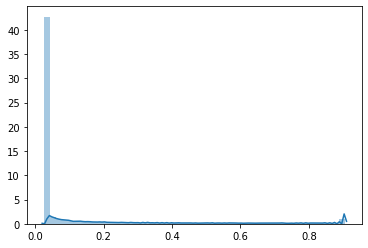

In [322]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.distplot(y_risk)


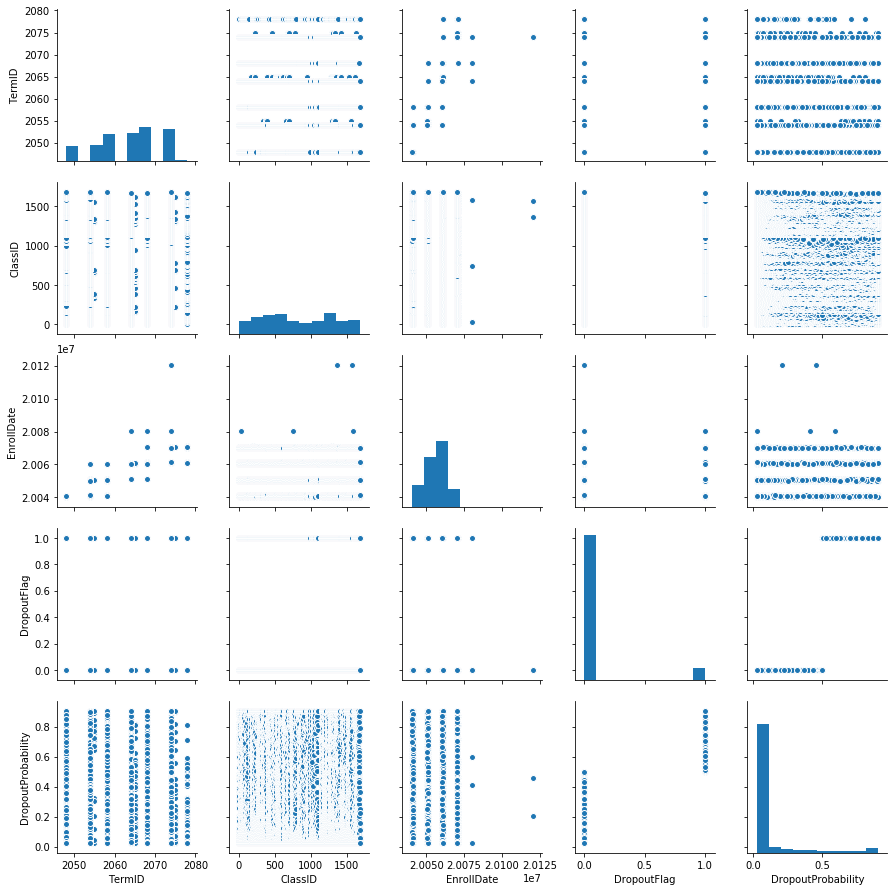

In [331]:
sns.pairplot(ReportingDF)